In [37]:
# setup
# file
import os

# Data Processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler

# model
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# explain
import seaborn as sns
import shap


# folder
folder_input = '02_input'

In [38]:
# import data
cleaned_data = pd.read_csv(os.path.join('..', folder_input, 'cleaned_data.csv'))

In [39]:
# train vs test
# seperate target from predictors
X = cleaned_data.copy()            # use copy, not to affect original dataset
y = X.pop('Churn')        # y = "churn", and delete churn from X

# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [40]:
# preprocessing for categorical data
cleaned_data.info()

# select categorical columns
# PS: [categorical_cols] mean == True
categorical_cols = X_train.dtypes == 'object'
categorical_cols = list(categorical_cols[categorical_cols].index)  
categorical_cols    

# categogical encoder
# PS: The output is a series, need to turn to dataframe
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# cat_encoder = OrdinalEncoder()
cat_cols_train = pd.DataFrame(cat_encoder.fit_transform(X_train[categorical_cols]))
cat_cols_test = pd.DataFrame(cat_encoder.fit_transform(X_test[categorical_cols]))

# One-hot encoding removed index; put it back
cat_cols_train.index = X_train.index
cat_cols_test.index = X_test.index

# add back colnames
cat_cols_train.columns = cat_encoder.get_feature_names_out()
cat_cols_test.columns = cat_encoder.get_feature_names_out()


# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, cat_cols_train], axis=1)
X_test = pd.concat([num_X_test, cat_cols_test], axis=1)


X_train.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Churn                  7043 non-null   bool   
 1   gender                 7043 non-null   object 
 2   SeniorCitizen          7043 non-null   int64  
 3   Partner                7043 non-null   object 
 4   Dependents             7043 non-null   object 
 5   FamilySize             7043 non-null   int64  
 6   PhoneService           7043 non-null   object 
 7   MultipleLines          7043 non-null   object 
 8   InternetService        7043 non-null   object 
 9   Is_Internet            7043 non-null   int64  
 10  OnlineSecurity         7043 non-null   object 
 11  OnlineBackup           7043 non-null   object 
 12  DeviceProtection       7043 non-null   object 
 13  TechSupport            7043 non-null   object 
 14  StreamingTV            7043 non-null   object 
 15  Stre

,SeniorCitizen,FamilySize,Is_Internet,tenure,MonthlyCharges,MonthlyChargesPerHead,Is_Contract_Locked,gender,Partner,Dependents,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,Contract
3296,0,1,1,19,84.75,84.750000,0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0
6397,0,3,1,72,71.45,23.816667,1,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
6043,0,3,1,61,99.15,33.050000,0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0
5309,0,3,0,34,24.95,8.316667,1,0.0,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3000,0,1,1,71,53.95,53.950000,1,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0


In [41]:
# preprocessing for numerical data
numericial_cols = cleaned_data.select_dtypes(include=['int64', 'float64']).columns

#scaler
num_encoder = MinMaxScaler()
num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[numericial_cols]))
num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[numericial_cols]))

#encoding removed index; put it back
num_cols_train.index = X_train.index
num_cols_test.index = X_test.index

# add back colnames
num_cols_train.columns = num_encoder.get_feature_names_out()
num_cols_test.columns = num_encoder.get_feature_names_out()

# Remove numerical  columns (will replace with encoding)
cat_X_train = X_train.drop(numericial_cols, axis=1)
cat_X_test = X_test.drop(numericial_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([cat_X_train, num_cols_train], axis=1)
X_test = pd.concat([cat_X_test, num_cols_test], axis=1)


X_train.head()



,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaperlessBilling,PaymentMethod,Contract,SeniorCitizen,FamilySize,Is_Internet,tenure,MonthlyCharges,MonthlyChargesPerHead,Is_Contract_Locked
3296,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,2.0,0.0,0.0,0.0,1.0,0.263889,0.661692,0.698354,0.0
6397,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,1.0,1.0,1.000000,0.529353,0.156162,1.0
6043,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1.0,1.0,0.847222,0.804975,0.238321,0.0
5309,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,1.0,0.0,0.472222,0.066667,0.018241,1.0
3000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.986111,0.355224,0.424292,1.0


In [42]:
X_train.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaperlessBilling,PaymentMethod,Contract,SeniorCitizen,FamilySize,Is_Internet,tenure,MonthlyCharges,MonthlyChargesPerHead,Is_Contract_Locked
3296,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,2.0,0.0,0.0,0.0,1.0,0.263889,0.661692,0.698354,0.0
6397,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,1.0,1.0,1.000000,0.529353,0.156162,1.0
6043,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1.0,1.0,0.847222,0.804975,0.238321,0.0
5309,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,1.0,0.0,0.472222,0.066667,0.018241,1.0
3000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.986111,0.355224,0.424292,1.0


In [43]:
X_train.shape[1]

22

In [44]:
# define model
# ie structure of the neural network

tf.random.set_seed(0)

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# model
tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape = [X_train.shape[1]]),   # non-linear
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid'),      # classification
])

# Outstanding: Add dropout and batch normalization (ref: kaggle learn; https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization/tutorial)

In [45]:
# model compile
# tell model what to adjust to  

tf_model.compile(
    loss = tf.keras.losses.binary_crossentropy,                   # for classification
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),         # what else to show in each epoch
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [46]:
# fit model 
history = tf_model.fit(
    X_train, 
    y_train,
    validation_data=[X_test, y_test], 
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping]
    )

Epoch 1/500
21/21 [==============================] - 3s 32ms/step - loss: 0.5650 - accuracy: 0.7264 - precision: 0.4831 - recall: 0.3437 - val_loss: 1.0180 - val_accuracy: 0.5077 - val_precision: 0.3416 - val_recall: 0.9629
Epoch 2/500
21/21 [==============================] - 0s 6ms/step - loss: 0.4390 - accuracy: 0.7815 - precision: 0.6157 - recall: 0.4848 - val_loss: 1.2726 - val_accuracy: 0.5366 - val_precision: 0.3561 - val_recall: 0.9672
Epoch 3/500
21/21 [==============================] - 0s 6ms/step - loss: 0.4272 - accuracy: 0.7900 - precision: 0.6212 - recall: 0.5485 - val_loss: 0.8923 - val_accuracy: 0.6014 - val_precision: 0.3889 - val_recall: 0.9323
Epoch 4/500
21/21 [==============================] - 0s 6ms/step - loss: 0.4236 - accuracy: 0.7931 - precision: 0.6380 - recall: 0.5209 - val_loss: 0.7179 - val_accuracy: 0.6513 - val_precision: 0.4207 - val_recall: 0.9039
Epoch 5/500
21/21 [==============================] - 0s 7ms/step - loss: 0.4205 - accuracy: 0.7980 - precis

Minimum Validation Loss: 0.4199


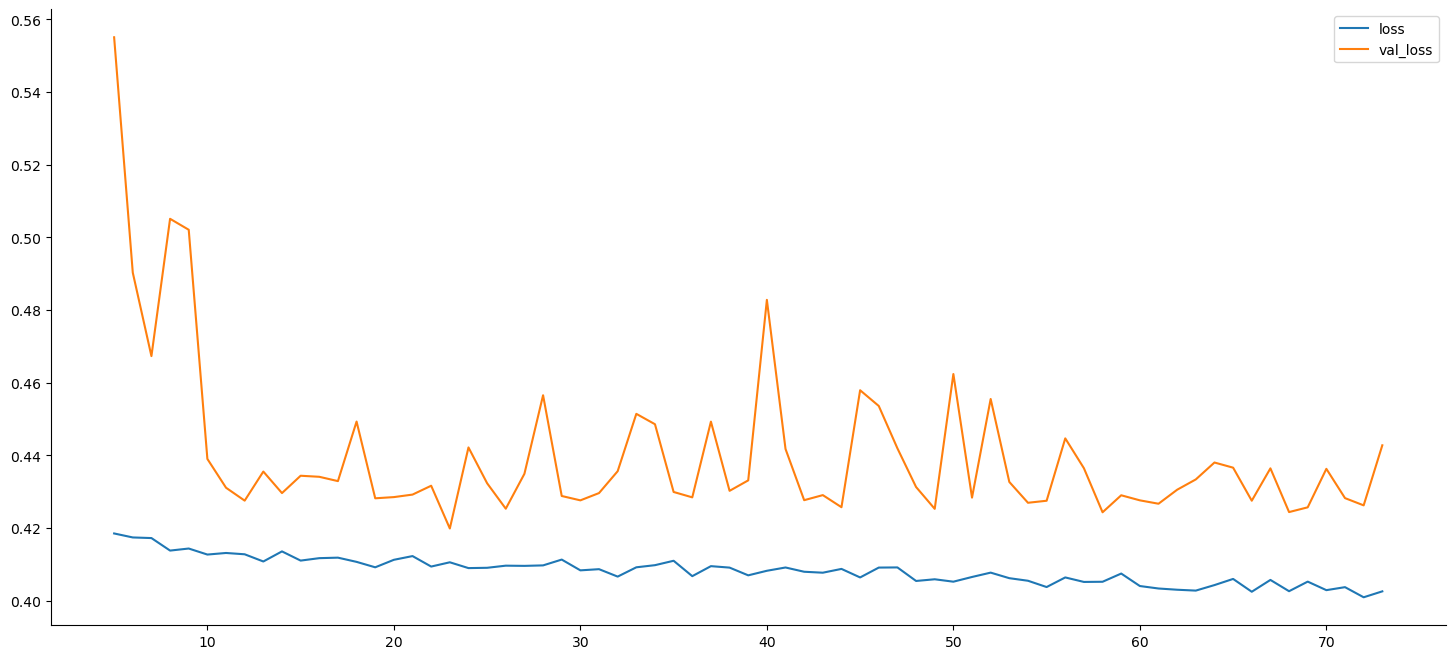

In [47]:
# kaggle learn way of evaluation

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [48]:
# epoch_used: for plotting on graph
epoch_used = len(history.history['loss'])+1      # python has to add 1 for order in the list
epoch_used

75

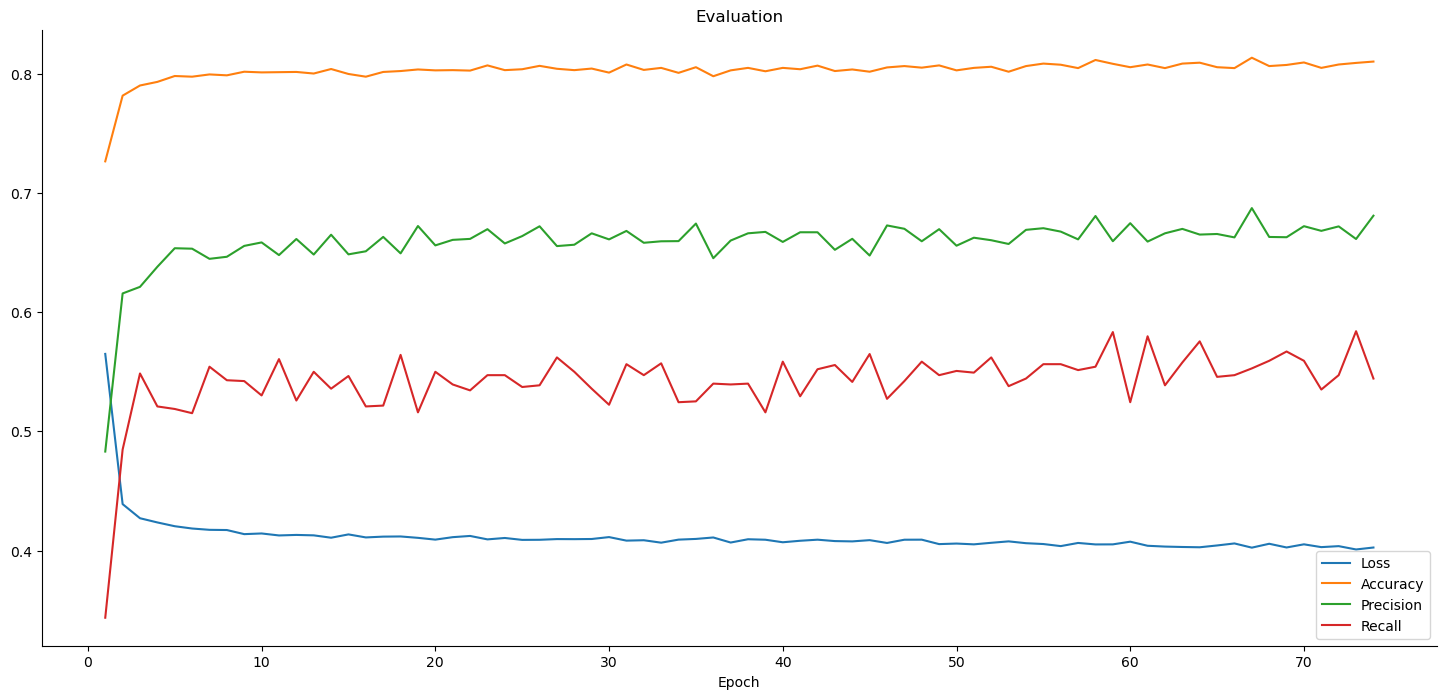

In [49]:
# set up matplotlib for model evaluation

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18,8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# plot
plt.plot(np.arange(1, epoch_used), history.history['loss'], label='Loss')
plt.plot(np.arange(1, epoch_used), history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(1, epoch_used), history.history['precision'], label='Precision')
plt.plot(np.arange(1, epoch_used), history.history['recall'], label='Recall')
plt.title('Evaluation')
plt.xlabel('Epoch')
plt.legend()

In [50]:
# prediction
# tf will output probailty instead of 1, 0
preds = tf_model.predict(X_test)

# turn preds into bool
# PS: if probabily >= 0.5, then True
preds_bool = preds >= 0.5


56/56 [==============================] - 0s 2ms/step


In [51]:
# evaluation
accuracy_score(y_test, preds_bool)

0.8091993185689949

In [52]:
# confusion matrix
confusion_matrix(y_test, preds_bool)

array([[1190,  113],
       [ 223,  235]], dtype=int64)

In [53]:
# classification report
print(classification_report(y_test, preds_bool))

              precision    recall  f1-score   support

       False       0.84      0.91      0.88      1303
        True       0.68      0.51      0.58       458

    accuracy                           0.81      1761
   macro avg       0.76      0.71      0.73      1761
weighted avg       0.80      0.81      0.80      1761



In [54]:
# To be done
# label encoder
# seperate phone and internet customers
# add batch normalization and dropout layer
# need to use shap for feature importance

